# LINER PDF Chat Tutorial (Simple ver.)

![](./images/liner-pdf-chat.gif)

본 튜토리얼은 **ChatGPT**를 활용해 **PDF** 파일에 기반하여 답변할 수 있는 질의응답 챗봇 코드를 다루고 있습니다. <br>
튜토리얼을 마치고 나면 위 그림과 같은 제품을 만드는 방법을 익히실 수 있게 됩니다. <br><br>

튜토리얼은 크게 **세 단계**로 나누어 진행됩니다.
- **PDF-to-Image**
- **Text Preprocessing**
- **Vector Search**


# 1. PDF-to-Text

PDF 파일에서 언어 모델이 이해할 수 있는 플레인 텍스트를 추출하는 과정입니다. <br>
해당 과정에는 PDF를 문서 이미지로 변환하는 `PDF-to-Image`, 문서 이미지에서 텍스트를 추출하는 `Image-to-Text` 로직이 포함됩니다.

## 1.1. PDF-to-Image

`PDF-to-Image`는 PDF 파일을 이미지 파일의 모음으로 변환하는 단계입니다. <br>
이 작업을 수행하기 위해 많은 기술들이 존재하지만, 본 튜토리얼에서는 [`pdf2image`](https://github.com/Belval/pdf2image)를 활용합니다. <br><br>
\* `pdf2image` 활용을 위해서는 `poppler` [설치](https://pdf2image.readthedocs.io/en/latest/installation.html)가 필요합니다.

In [1]:
# pdf2image 라이브러리 임포트
from pdf2image import convert_from_path

본 튜토리얼에서는 2017년 공개된 [**Attention Is All You Need**](https://arxiv.org/abs/1706.03762) 논문을 예제 문서로 활용합니다.

In [2]:
# 로컬 내 PDF 파일 경로 변수로 지정
FILE_NAME = "transformer.pdf"

In [3]:
# `convert_from_path` 함수 통해 PDF 파일 읽어와 이미지 리스트로 변환
images = convert_from_path(FILE_NAME)

In [4]:
len(images)

15

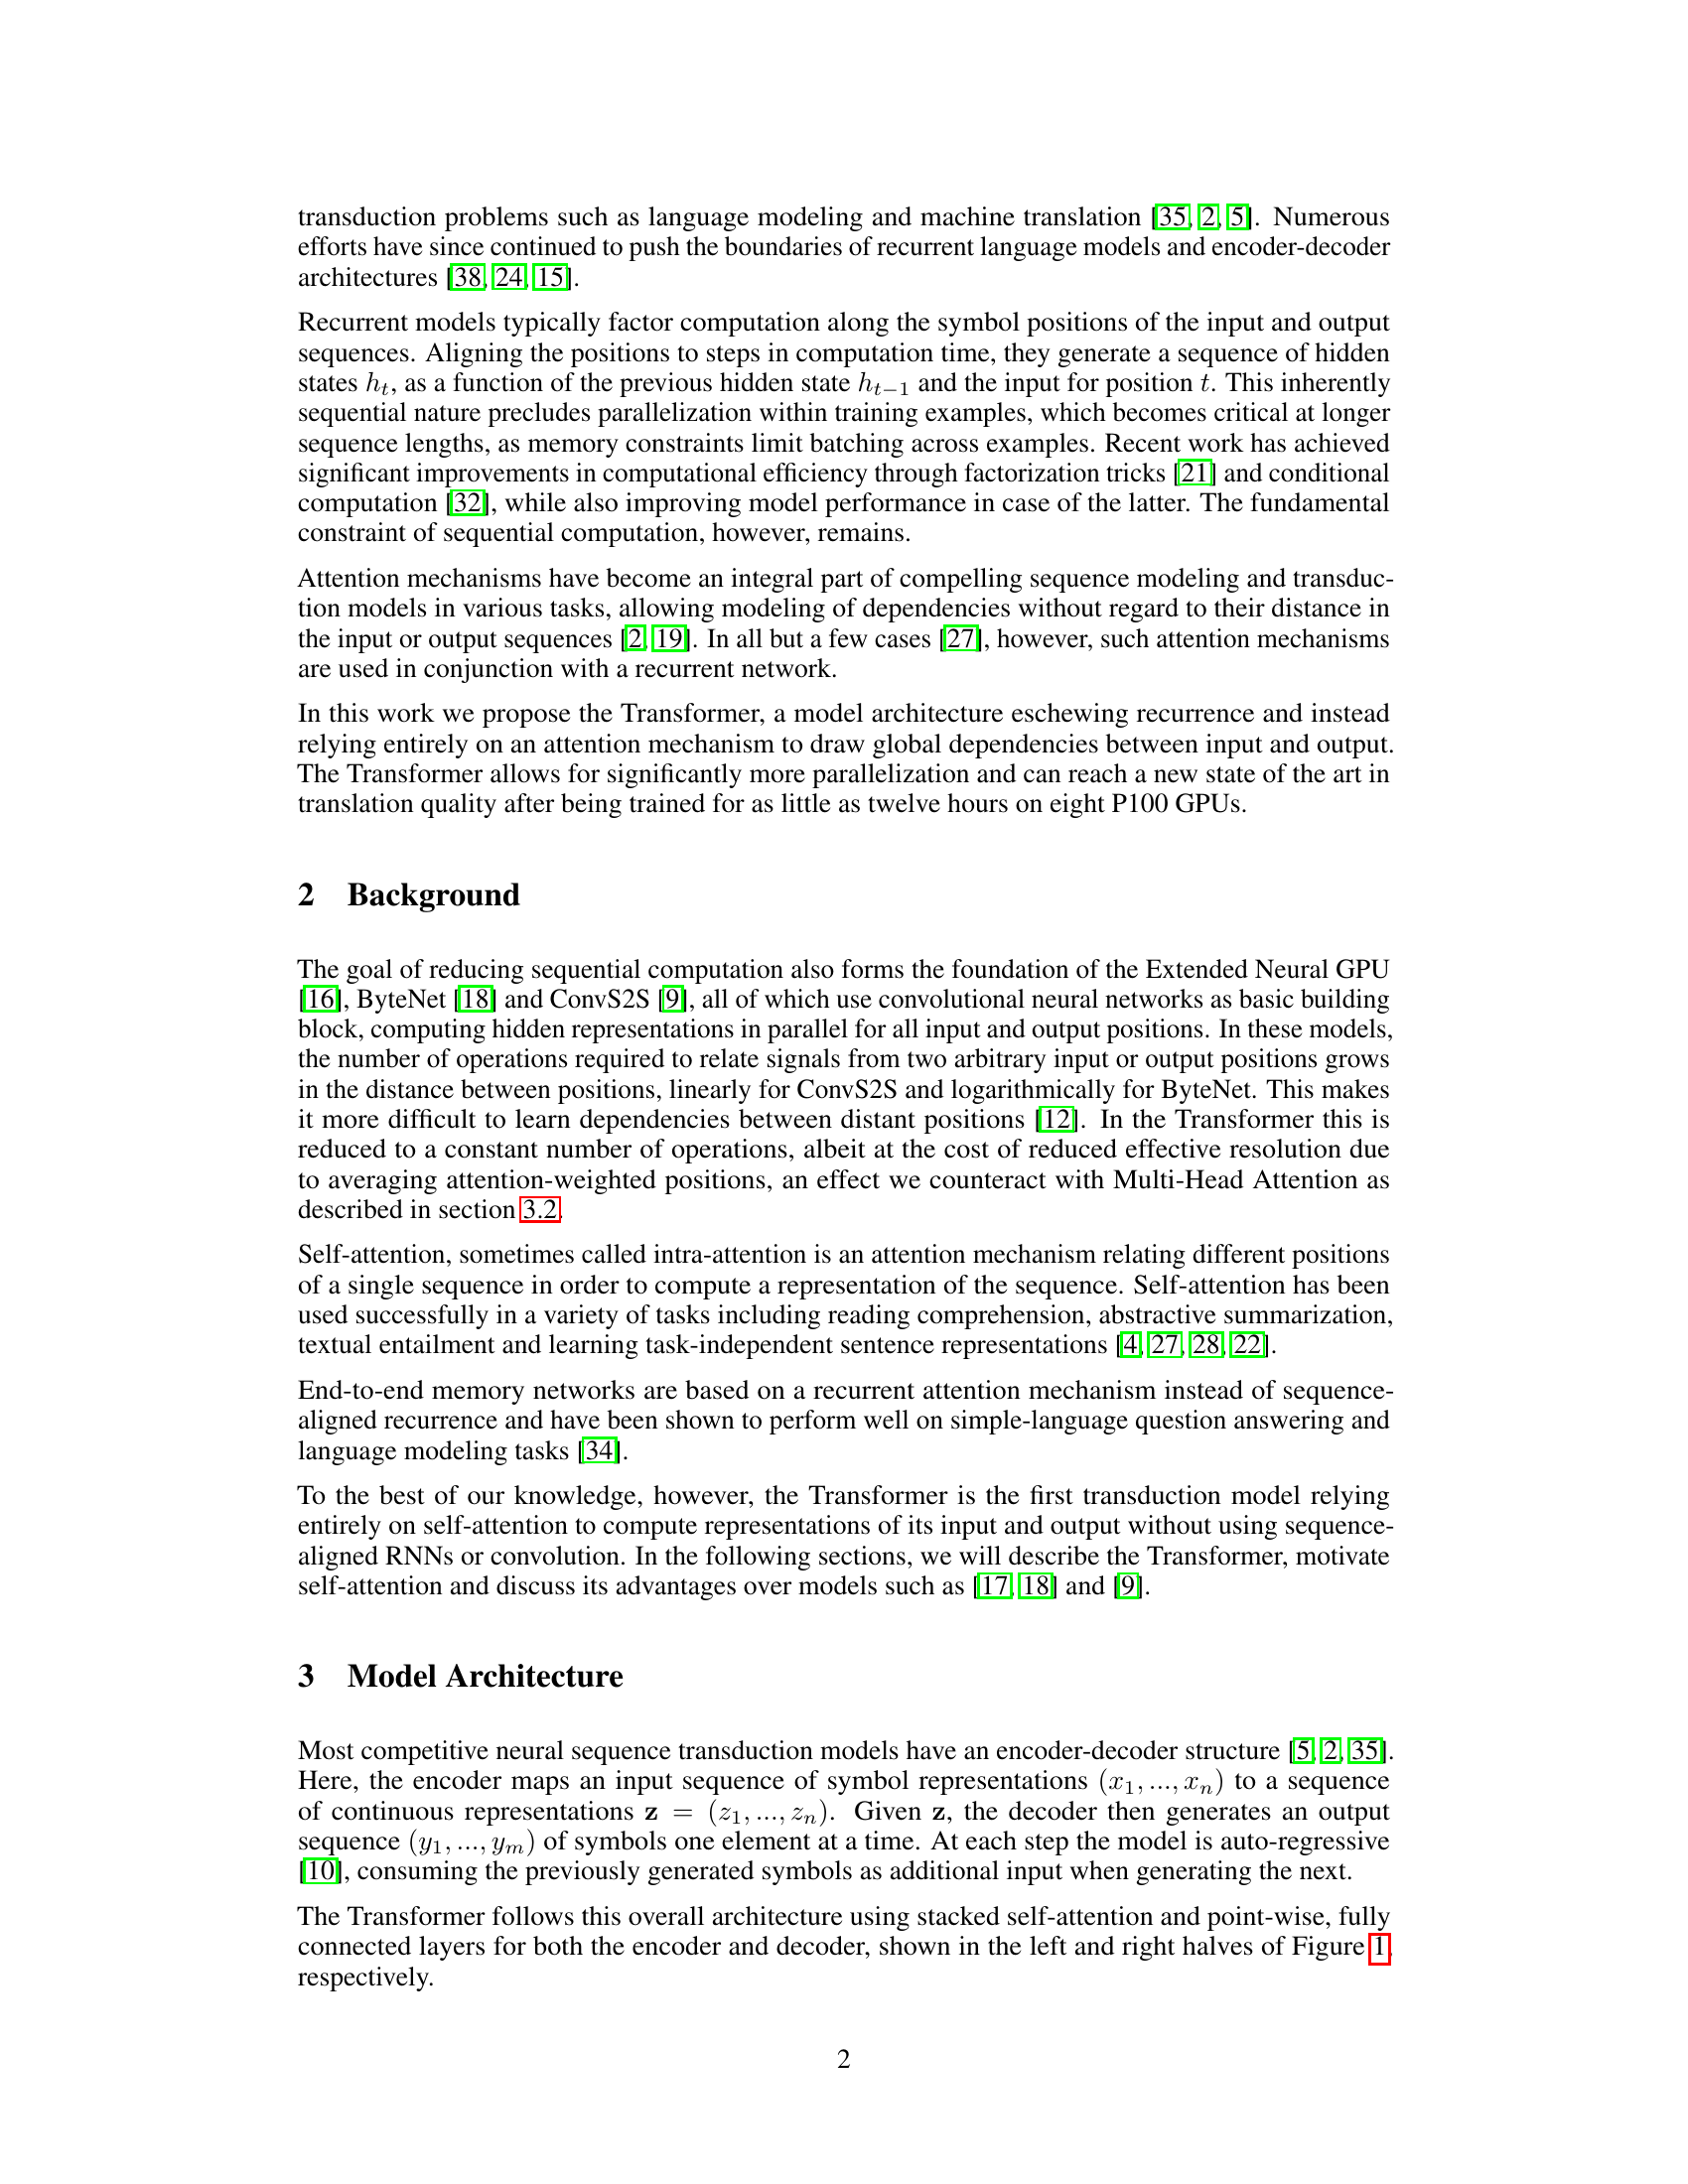

In [5]:
# 변환된 이미지 확인
images[1]

In [6]:
# 다음 단계를 위해 이미지 파일 로컬에 저장
for i, image in enumerate(images):
    image.save(f"page_{str(i)}.jpg", "JPEG")

## 1.2. Image-to-Text

`Image-to-Text`는 앞서 저장한 이미지 파일에서 텍스트를 추출하는 단계입니다. <br>
본 튜토리얼에서는 [`Google OCR`](https://cloud.google.com/vision/docs/ocr)을 활용하며, 기호에 따라 다른 OCR 기술 (e.g. [HuggingFace](https://huggingface.co/), [Tesseract](https://github.com/tesseract-ocr/tesseract), ...) 을 활용하실 수도 있습니다.

In [7]:
# Google OCR 라이브러리 임포트
import io
from tqdm import tqdm
from google.cloud import vision

client = vision.ImageAnnotatorClient()

In [8]:
# Google OCR을 활용하여 이미지 파일에서 텍스트를 추출하는 메서드
def detect_text(path: str):
    with io.open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response.full_text_annotation

In [9]:
detect_text("page_1.jpg").text

'transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous\nefforts have since continued to push the boundaries of recurrent language models and encoder-decoder\narchitectures [38, 24 15.\nRecurrent models typically factor computation along the symbol positions of the input and output\nsequences. Aligning the positions to steps in computation time, they generate a sequence of hidden\nstates ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently\nsequential nature precludes parallelization within training examples, which becomes critical at longer\nsequence lengths, as memory constraints limit batching across examples. Recent work has achieved\nsignificant improvements in computational efficiency through factorization tricks [21] and conditional\ncomputation [32], while also improving model performance in case of the latter. The fundamental\nconstraint of sequential computation, however, remains.\nAttention me

Google OCR에서 내려준 결과를 곧바로 활용할 경우 위 예시와 같이 각 행의 마지막에 위치한 **띄어쓰기**, **개행** 등의 *Break* 정보가 유실된 상태의 텍스트 (e.g. `Numerous` 뒤에 불필요한 개행문자가 포함) 를 얻게 됩니다.<br>
Google도 이러한 점을 고려해 [**Break Detection**](https://cloud.google.com/dotnet/docs/reference/Google.Cloud.Vision.V1/latest/Google.Cloud.Vision.V1.TextAnnotation.Types.DetectedBreak.Types.BreakType) 기술을 제공하고 있습니다. <br>
따라서 *Break Detection* 에 의해 추론된 결과에 따라 **띄어쓰기**, **개행** 등을 올바르게 정렬하는 후처리 작업을 진행합니다.

In [10]:
breaks = vision.TextAnnotation.DetectedBreak.BreakType

In [11]:
dir(breaks)

['EOL_SURE_SPACE',
 'HYPHEN',
 'LINE_BREAK',
 'SPACE',
 'SURE_SPACE',
 'UNKNOWN',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [12]:
# Break Detection 결과 적용을 위한 후처리 메서드
def postprocess_ocr(annotation) -> str:
    text = ""

    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        detected_break = symbol.property.detected_break
                        detected_break_type = detected_break.type_

                        if detected_break_type == breaks.UNKNOWN:
                            text += symbol.text
                        elif detected_break_type == breaks.SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.SURE_SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.EOL_SURE_SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.HYPHEN:
                            text += f"{symbol.text}-"
                        elif detected_break_type == breaks.LINE_BREAK:
                            text += f"{symbol.text}\n"

    return text.strip()

*Break Detection* 정제 로직이 적용된 후처리 결과는 아래와 같습니다.

In [13]:
postprocess_ocr(detect_text("page_1.jpg"))

'transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24 15.\nRecurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work has achieved significant improvements in computational efficiency through factorization tricks [21] and conditional computation [32], while also improving model performance in case of the latter. The fundamental constraint of sequential computation, however, remains.\nAttention mechanisms 

이제 모든 데이터에 **OCR**과 *Break Detection* 후처리를 적용합니다.

In [14]:
documents = []

In [15]:
for i in tqdm(range(len(images))):
    documents.append(
        {
            "page": int(i+1),
            "text": postprocess_ocr(detect_text(f"page_{i}.jpg")),
        }
    )

100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


In [16]:
documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v5 [cs.CL] 6 Dec 2017\nAttention Is All You Need\nAshish Vaswani* Google Brain avaswani@google.com\nLlion Jones* Google Research llion@google.com\nNoam Shazeer* Google Brain noam@google.com\nNiki Parmar* Google Research nikip@google.com\nAidan N. Gomez* †\nUniversity of Toronto aidan@cs.toronto.edu\nIllia Polosukhin* ‡\nillia.polosukhin@gmail.com\nAbstract\nJakob Uszkoreit* Google Research usz@google.com\nŁukasz Kaiser* Google Brain lukaszkaiser@google.com\n*Work performed while at Google Brain.\n*Work performed while at Google Research.\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two ma

In [17]:
len(documents)

15

# 2. Text Pre-processing

언어 모델이 보다 잘 이해할 수 있는 단위로 텍스트 데이터를 **정제**하는 과정입니다. <br>
해당 과정에는 불필요한 텍스트를 제거하는 `Text Cleansing`, 텍스트를 보다 작은 의미 단위로 분할하는 `Text Chunking` 로직이 포함됩니다. <br>
일반적으로 문서 전처리에 따라 **서비스 품질이 크게 달라질 수 있기에** 이 과정에 튜토리얼 코드 이상으로 많은 공을 들이는게 좋습니다.

## 2.1. Text Cleansing

`Text Cleansing`은 문서 활용과 벡터화에 있어 불필요한 문자열을 제거하는 단계입니다. <br>
본 로직은 도메인 특성에 따라 다르게 작성될 수 있습니다. 본 튜토리얼에서는 **최소 단위 정제 작업**만 진행합니다. <br>
활용하시는 목적에 따라 아래 메서드에 추가 로직을 작성해주시면 됩니다.

In [18]:
import re
from typing import List, Optional


citation_pattern = r"\[\d+\]"

def cleanse_text(text: str) -> Optional[str]:
    # 길이 단위 필터링
    if len(text) <= 5:
        return None

    # 각주 제거
    text = re.sub(citation_pattern, "", text)
        
    # 불필요하게 나열된 여러 개 공백 제거
    text = re.sub(" +", " ", text)
    return text

가볍게 작성한 `cleanse_text` 함수에 더러운 문자열을 넘겨 봅니다.

In [19]:
dirty_text = """We show that the  Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large    and limited   training data.\n1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random.   Jakob proposed replacing RNNs with self-attention and started   the effort to evaluate this idea."""

In [20]:
dirty_text

'We show that the  Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large    and limited   training data.\n1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random.   Jakob proposed replacing RNNs with self-attention and started   the effort to evaluate this idea.'

In [21]:
cleanse_text(dirty_text)

'We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.\n1 Introduction\nRecurrent neural networks, long short-term memory and gated recurrent neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea.'

계획한 대로 불필요한 주석 기호와 공백 등이 사라지는 것을 확인할 수 있습니다.

## 2.2. Text Chunking

`Text Chunking`은 하나의 벡터에 명료하고 확실한 정보를 담기 위해 텍스트를 **의미적으로 자르는 단계**입니다. <br>
대개 문단 단위로 자르는 로직, 토큰 갯수로 자르는 로직 등이 있으며 본 튜토리얼에서는 편의상 **토큰 갯수**로 자르는 로직을 구현합니다. <br>
`Text Cleansing`과 마찬가지로 목적에 따라 다른 분할 로직을 활용하시는게 바람직합니다.

**OpenAI**는 토큰 단위 비즈니스 로직을 지원하기 위해 문장의 토큰 갯수를 반환해주는 [`tiktoken`](https://github.com/openai/tiktoken) 라이브러리를 제공합니다. <br>
본 튜토리얼에서는 `tiktoken`을 활용해 토큰 갯수 기반 청킹을 적용합니다.

In [22]:
# tiktoken 라이브러리 임포트
import tiktoken

In [23]:
# ChatGPT 인코딩 로직인 `cl100k_base`를 기본 인코딩으로 설정
tokenizer = tiktoken.get_encoding("cl100k_base")

In [24]:
# 입력 문장의 토큰 갯수를 카운트 하는 메서드
def num_tokens_from_text(text: str) -> int:
    num_tokens = len(tokenizer.encode(text))
    return num_tokens

In [25]:
# 최대 토큰 갯수 지정
CHUNK_SIZE = 256

이제 각 문서를 개행 단위로 분할한 뒤, `chunk`에 더해가며 `CHUNK_SIZE`를 초과하면 `chunks`에 추가해주는 반복 로직을 수행합니다.

In [26]:
# 토큰 갯수 단위로 문서 분할하는 메서드
def chunkify(text: str) -> List[str]:
    lines = text.split("\n")

    chunks = []

    chunk = ""
    for line in lines:
        line = cleanse_text(line)
        if line is None:
            continue

        chunk += f" {line}"

        if num_tokens_from_text(chunk) >= CHUNK_SIZE:
            chunks.append(chunk.strip())
            chunk = ""

    # 마지막 청크가 남아 있다면 추가하며 마무리
    if chunk:
        chunks.append(chunk)

    return chunks

In [27]:
chunks = chunkify(documents[0]["text"])

In [28]:
chunks[0]

'arXiv:1706.03762v5 [cs.CL] 6 Dec 2017 Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* ‡ illia.polosukhin@gmail.com Abstract Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com *Work performed while at Google Brain. *Work performed while at Google Research. The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these m

0번째 이미지가 `chunk` 단위로 쪼개진 것을 확인할 수 있습니다. <br>
이제 앞서 변환해둔 모든 문서 데이터에 `Text Chunking` 로직을 적용해줍니다.

In [29]:
chunked_documents = []

In [30]:
for document in documents:
    chunks = chunkify(document["text"])
    for chunk in chunks:
        chunked_documents.append(
            {
                "page": document["page"],
                "text": chunk,
            }
        )

In [31]:
chunked_documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v5 [cs.CL] 6 Dec 2017 Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* ‡ illia.polosukhin@gmail.com Abstract Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com *Work performed while at Google Brain. *Work performed while at Google Research. The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translati

이제 앞서 15개였던 문서가 Chunk 단위로 더 많은 양의 문서로 분할되었음을 확인할 수 있습니다.

In [32]:
len(chunked_documents)

36

# 3. Vector Search

사용자 질의에 부합하는 문서를 반환 받기 위해 문서를 벡터 검색 엔진에 추가하고, 활용하는 과정입니다. <br>
문서를 벡터화하는 `Embedding`, 임베딩 된 문서를 검색해오는 `Hybrid Search` 로직이 포함됩니다.

## 3.1. Embedding

![](./images/openai-vectors.svg)<br><br>
`Embedding`은 검색 엔진에 등록할 문서의 텍스트를 벡터로 변환하는 단계입니다. <br>
텍스트 임베딩을 위해 다양한 기술을 활용할 수 있지만, 본 튜토리얼에서는 [**Ada V2 Embedding**](https://platform.openai.com/docs/guides/embeddings/second-generation-models)을 활용합니다. <br><br>
\* 임베딩에 대한 이해를 보다 가꾸고자 하는 분은 [링크](http://jalammar.github.io/illustrated-word2vec/)를 참조해주세요.

In [33]:
# openai 라이브러리 임포트
import openai

In [34]:
# openai API Key 설정
openai.api_key = "YOUR_OPENAI_KEY"

In [35]:
# 앞서 준비한 문서 데이터를 순회하며 벡터 추출 후, 문서 객체에 벡터 추가 할당
for chunked_document in tqdm(chunked_documents):
    embedding = openai.Embedding.create(
        input=chunked_document["text"],
        model="text-embedding-ada-002",
    )["data"][0]["embedding"]

    chunked_document["embedding"] = embedding

100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


In [36]:
chunked_documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v5 [cs.CL] 6 Dec 2017 Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* ‡ illia.polosukhin@gmail.com Abstract Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com *Work performed while at Google Brain. *Work performed while at Google Research. The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translati

## 3.2. Hybrid Search

`Hybrid Search`는 사용자 질의에 따라 레퍼런스가 될 수 있는 문서를 검색하는 단계입니다. <br>
23년 기준 많은 벡터 서치 엔진이 개발되고 있지만, 현재 기준 개발 편의성이 가장 높은 [**Pinecone**](https://www.pinecone.io/)을 활용합니다.

![](./images/pinecone-index.png)

먼저 **Pinecone**에서 활용할 인덱스를 생성해줍니다. <br>
[**Ada V2 Embedding**](https://platform.openai.com/docs/guides/embeddings/second-generation-models)이 **1536차원**의 벡터를 반환하므로 해당 값을 `Dimensions`에, 유사도 검색에 활용하고자 하는 메트릭을 `Metric`에 선택해주면 됩니다.

![](./images/before-upsert.png)

인덱스가 생성된 후, **`Index Info`** 드롭다운을 열어주면 아직 등록된 벡터가 없는 것을 확인할 수 있습니다.<br>
이제 앞서 생성한 벡터 정보를 해당 인덱스에 등록해주는 작업을 진행합니다.

In [37]:
# pinecone 라이브러리 임포트
import pinecone

/Users/karter/opt/anaconda3/envs/dev/lib/python3.8/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [38]:
# pinecone API Key 설정
pinecone.init(api_key="YOUR_PINECONE_KEY", environment="YOUR_PINECONE_ENV")

In [39]:
# pinecone 등록 인덱스 확인
active_indexes = pinecone.list_indexes()

아래 변수에 앞서 생성한 **Pinecone Index**가 담겨 있어야 합니다.

In [40]:
active_indexes

['classnow']

이제 문서 데이터를 **Pinecone**에 등록하기 위해 벡터 데이터를 튜플 형태로 생성합니다.

In [41]:
vectors = [
    (
        f"vec{str(i)}",                  # 문서 아이디
        chunked_document["embedding"],   # 벡터
        {                                # 문서 메타 정보 딕셔너리
            "text": chunked_document["text"],
            "page": chunked_document["page"],
            "file": FILE_NAME,
        },
    )
    for i, chunked_document in enumerate(chunked_documents)
]

In [42]:
vectors[0]

('vec0',
 [-0.041452743113040924,
  0.014445236884057522,
  0.037466902285814285,
  -0.014926286414265633,
  0.027694720774888992,
  0.01522866077721119,
  -0.011421495117247105,
  -0.009703461080789566,
  0.002906915033236146,
  -0.036064986139535904,
  0.020547697320580482,
  0.02968764118850231,
  -0.0016080805798992515,
  0.018458565697073936,
  -0.0054289898835122585,
  0.004700543358922005,
  0.01981925033032894,
  0.005514891818165779,
  -0.007112664170563221,
  -0.01701541617512703,
  -0.031089559197425842,
  0.006710643880069256,
  -0.0078204944729805,
  0.013008959591388702,
  -0.0013967623235657811,
  0.011545194312930107,
  0.02784590795636177,
  -0.020451486110687256,
  -0.023873811587691307,
  -0.02878051996231079,
  0.01838984526693821,
  0.020795093849301338,
  -0.00510943541303277,
  -0.014019164256751537,
  -0.011510833166539669,
  -0.014967519789934158,
  0.010273848660290241,
  -0.011222203262150288,
  0.024134952574968338,
  -0.009387342259287834,
  0.0418375842273

In [43]:
len(vectors)

36

In [44]:
# 인덱스 설정
index = pinecone.Index("classnow")

# 설정된 인덱스에 앞서 생성한 벡터 데이터 Upsert
index.upsert(
    vectors=vectors,
    namespace="pdf_vectors",
)

{'upserted_count': 36}

![](./images/after-upsert.png)

방금 `upsert` 작업을 통해 **36개**의 벡터가 인입되었습니다. <br>
이제 검색 엔진이 사용자 쿼리에 부합하는 문서 데이터를 가져오는지 확인해보겠습니다.

In [45]:
# 사용자 쿼리 벡터화 위한 메서드
def query_embed(text: str) -> List[float]:
    embedding = openai.Embedding.create(
        input=text,
        model="text-embedding-ada-002",
    )["data"][0]["embedding"]

    return embedding

In [46]:
# 사용자 쿼리 벡터화
query_vector = query_embed("What advantages do transformers have over RNNs?")

In [47]:
# 사용자 쿼리 벡터와 `filter` 로직을 활용해 Hybrid Search
query_response = index.query(
    namespace="pdf_vectors",
    top_k=10,
    include_values=True,
    include_metadata=True,
    vector=query_vector,
    filter={
        "file": {"$in": [FILE_NAME]},
    }
)

위 코드를 보면 `query_vector` 외에도 `filter` 인자를 추가로 넘겨주는 것을 확인할 수 있습니다. <br>
`filter` 인자에 따라 특정 **file** 명을 지닌 문서 데이터 중에서 가장 유사한 문서를 반환하게끔 하는 **Hybrid Search** 적용이 가능해집니다.

In [48]:
# Top-1으로 매칭된 데이터 확인
query_response["matches"][0]["metadata"]

{'file': 'transformer.pdf',
 'page': 10.0,
 'text': 'In contrast to RNN sequence-to-sequence models , the Transformer outperforms the Berkeley-Parser even when training only on the WSJ training set of 40K sentences. 7 Conclusion In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention. For translation tasks, the Transformer can be trained significantly faster than architectures based on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task our best model outperforms even all previously reported ensembles. We are excited about the future of attention-based models and plan to apply them to other tasks. We plan to extend the Transformer to problems involving input and output modalities other than text an

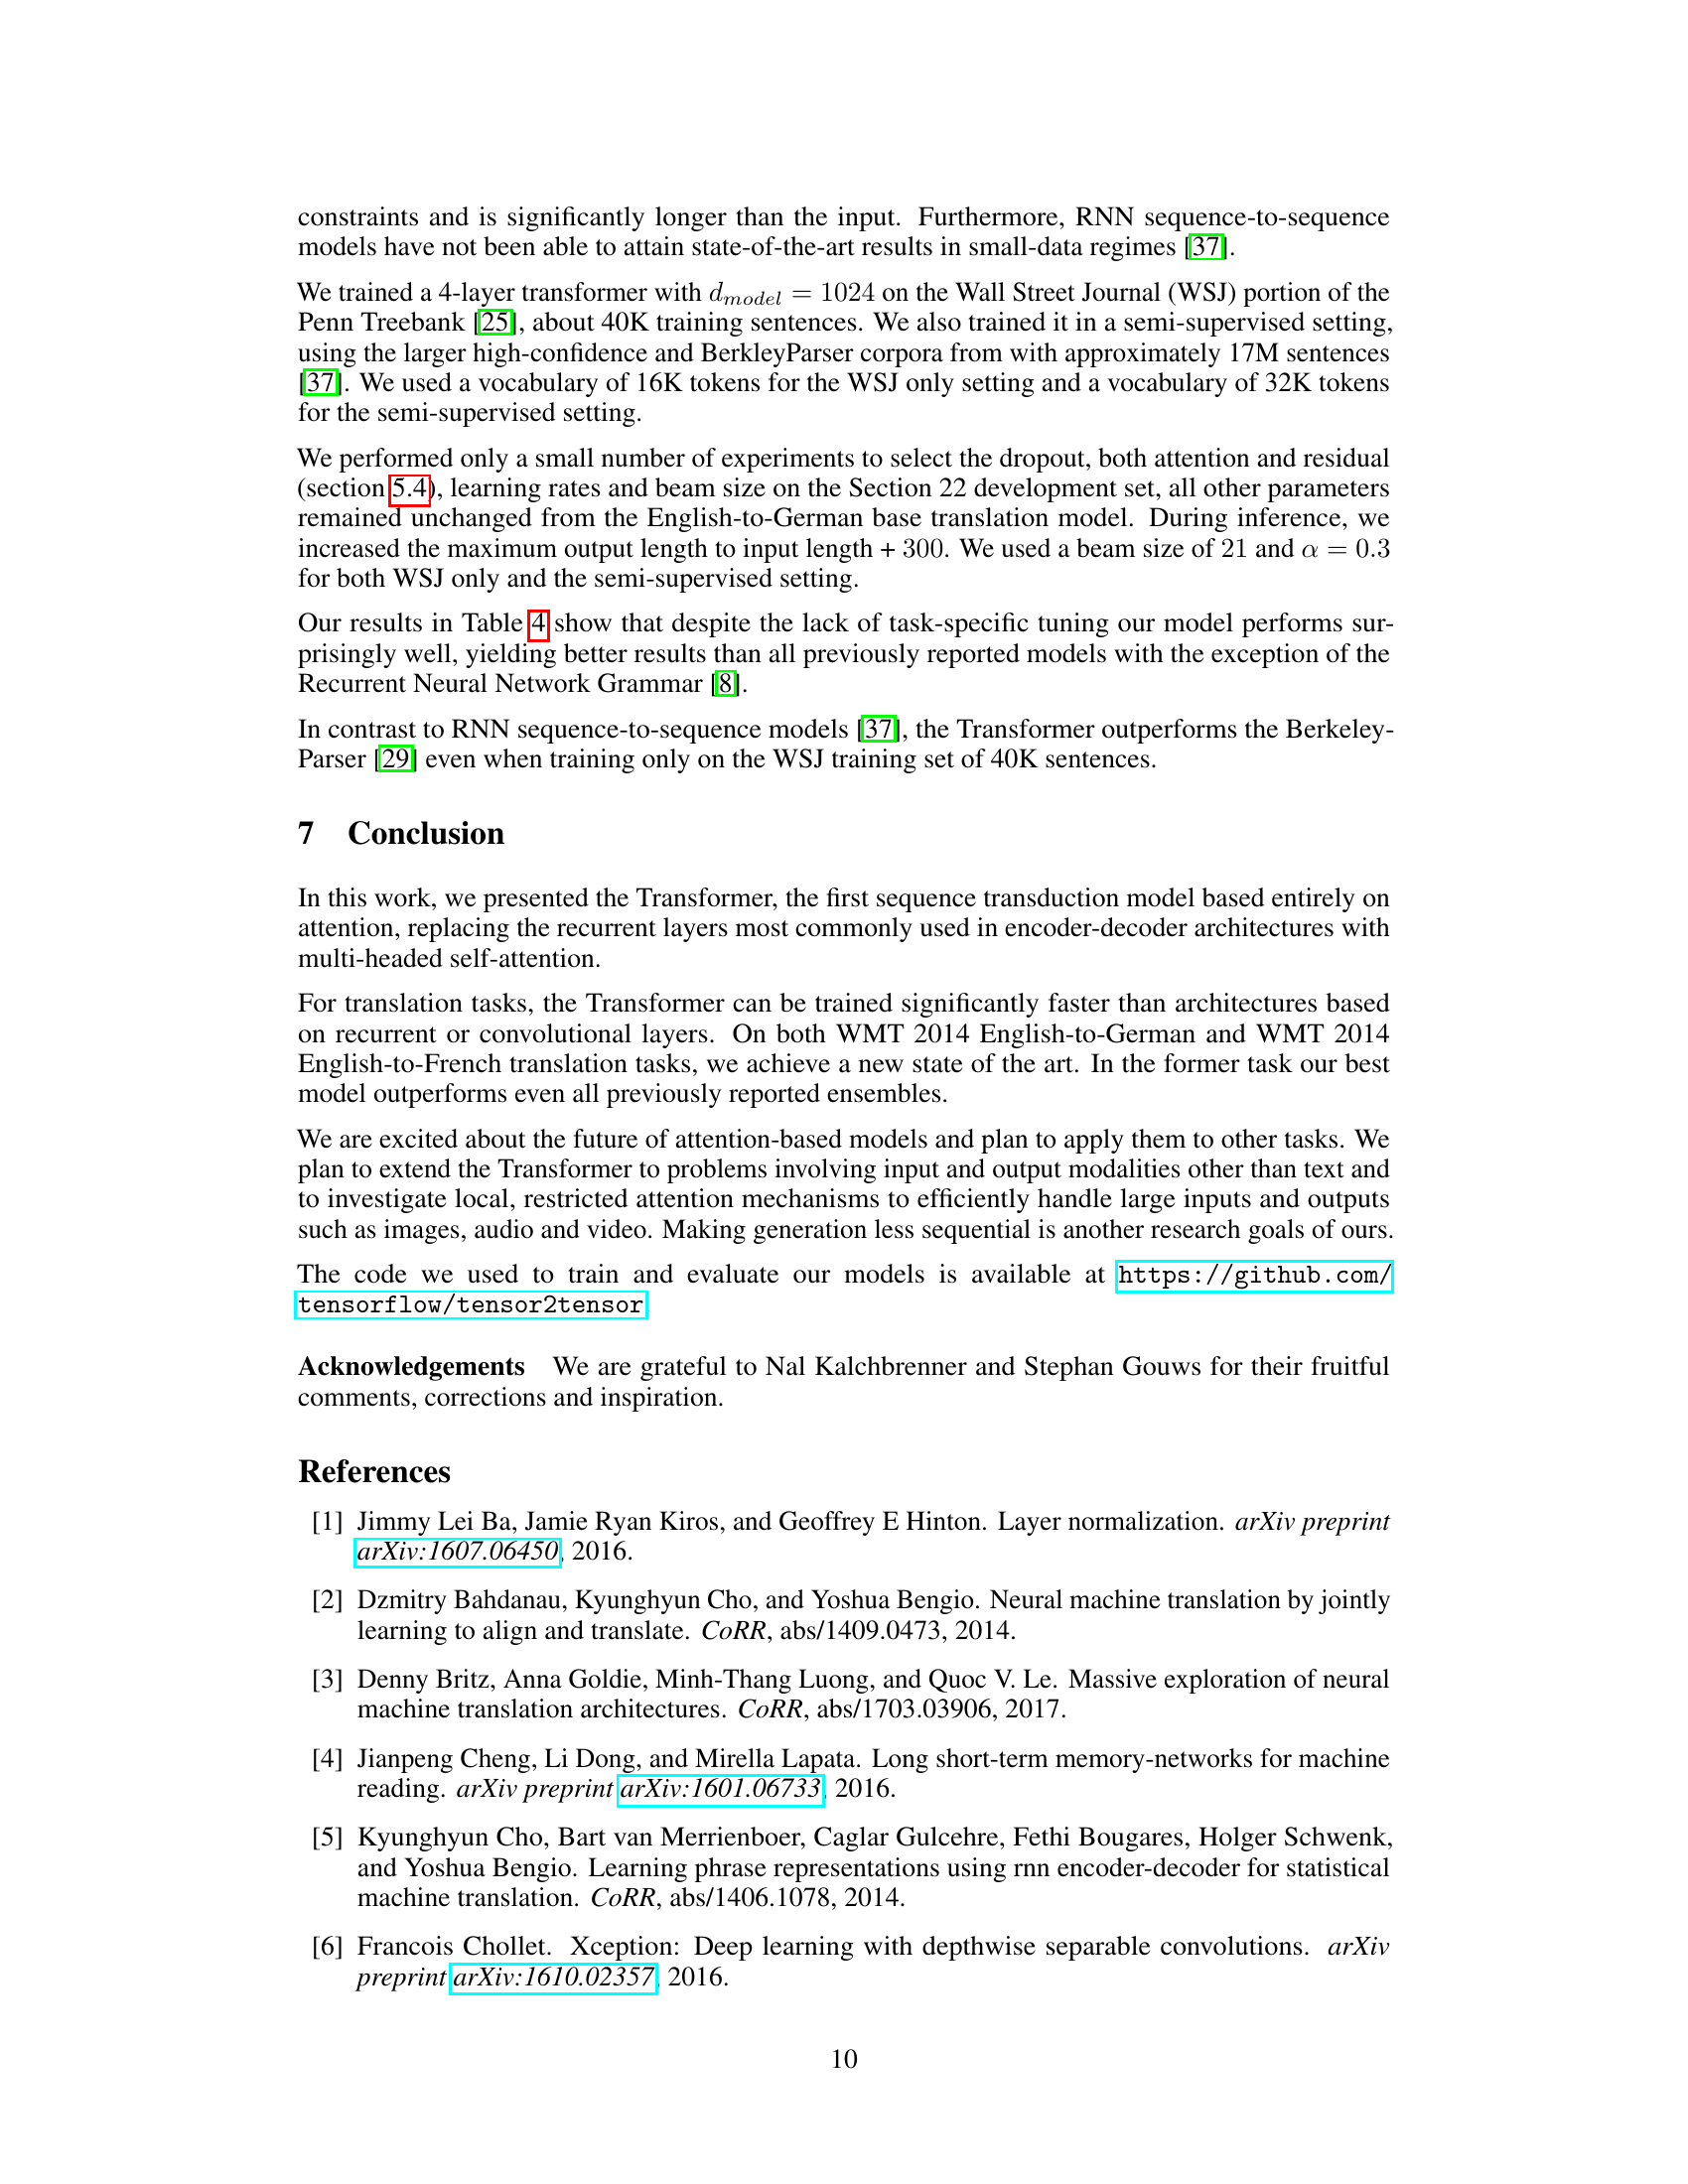

In [49]:
# PDF 중 몇 번째 페이지에서 근거를 찾을 수 있었는지 확인
images[int(query_response["matches"][0]["metadata"]["page"])-1]

# Simple PDF Chat

이제 기본적인 기능 구현을 위한 로직들의 개발이 완료되었습니다. <br>
최종적으로 아래와 같은 함수를 구현해 위 모든 과정을 하나의 로직으로 통합할 수 있습니다.

In [50]:
def pdf_chat(query: str) -> str:
    # 1. 사용자 쿼리 벡터화
    query_vector = query_embed(query)

    # 2. Hybrid Search 통해 레퍼런스 문서 반환
    query_response = index.query(
        namespace="pdf_vectors",
        top_k=10,
        include_values=True,
        include_metadata=True,
        vector=query_vector,
        filter={
            "file": {"$in": [FILE_NAME]},
        },
    )

    reference = query_response["matches"][0]["metadata"]

    # 3. 프롬프트에 레퍼런스 문서 정보와 사용자 쿼리 정보 입력
    resp = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "\n".join([
                "Your role is to answer the user's query based on the references provided.",
                "You must base your answer solely on the references, regardless of your own knowledge, and you must include the page information in your answer.",
            ])},
            {"role": "system", "content": f"reference: {reference['text']}, page: ({int(reference['page'])})"},
            {"role": "user", "content": query},
        ]
    )

    # 4. LLM 생성 답변 반환
    answer = resp["choices"][0]["message"]["content"]
    return answer

In [51]:
response = pdf_chat("What advantages do transformers have over RNNs?")

In [52]:
response

'According to the reference provided, "the Transformer outperforms the Berkeley-Parser even when training only on the WSJ training set of 40K sentences." The Transformer, the first sequence transduction model based entirely on attention ", replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention." Furthermore, "on both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task our best model outperforms even all previously reported ensembles" [page 10]. This suggests that the Transformer has improved performance and efficiency over RNNs.'

# Future Work

본 튜토리얼에 소개된 기능 외에도 추가적으로 아래와 같은 기능을 구현해볼 수 있습니다.

- **Multi-turn Chat**: 싱글 턴 대화가 아닌 멀티 턴 대화를 이어나가기 위해 대화 이력을 관리 및 활용해볼 수 있습니다.
- **Query Refinement**: 검색 로직을 개선하기 위해 쿼리를 정제 및 강화해주는 로직을 더해볼 수 있습니다.
- **Term-based Search**: 필터, 벡터 기반 검색 외 키워드 기반 검색을 더해볼 수 있습니다.

# Contributors

- Luke Kim
- [Karter Heo](karter@linercorp.com)